In [21]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

#AWS
import boto3
from botocore.exceptions import ClientError
from io import StringIO

In [22]:
def readfromS3(filename):
    path = 's3://lendingclubdatastore/'
    bucket = path + filename  # already created on S3
    client = boto3.resource('s3')
    df = pd.read_csv(bucket)
    return df

In [23]:
loans = readfromS3('loans_updated.csv')
loans.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term,return
0,1,30000,30000,30000.0,36,22.35,1151.16,D,5.0,MORTGAGE,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.029381
1,2,20000,20000,20000.0,36,7.56,622.68,A,12.0,MORTGAGE,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.359654
2,3,4500,4500,4500.0,36,11.31,147.99,B,12.0,RENT,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.364571
3,4,20000,20000,20000.0,60,17.97,507.55,D,4.0,RENT,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.013577
4,5,6600,6600,6325.0,36,11.31,217.05,B,12.0,RENT,...,382.001841,0.0,0.0,Cash,N,Not Applicable,0.0,0.0,0.0,0.115197


In [24]:
loans.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag', 'settlement_status',
       'settlement_amount', 'settlement_percentage', 'settlement_term',
       'return'],
      dtype='object', length=126)

In [25]:
loans.columns[loans.isnull().any()]

Index([], dtype='object')

In [26]:
#train dataset label encoding
for i in ('grade','loan_status','home_ownership','verification_status','pymnt_plan','initial_list_status','application_type',
          'verification_status_joint','hardship_flag','hardship_reason','hardship_status','hardship_loan_status',
          'hardship_type','debt_settlement_flag','settlement_status','disbursement_method'):
    le = LabelEncoder()
    le.fit(loans[i])
    encoded = le.transform(loans[i])
    loans[i] = encoded

member_id                 0.041967
loan_amnt                -0.060493
funded_amnt              -0.060541
funded_amnt_inv          -0.060294
term                     -0.166149
int_rate                 -0.244912
installment              -0.043349
grade                    -0.248003
emp_length                0.015510
home_ownership           -0.068871
annual_inc                0.040826
verification_status      -0.084563
loan_status               1.000000
pymnt_plan                     NaN
dti                      -0.086095
delinq_2yrs              -0.019404
inq_last_6mths           -0.061059
mths_since_last_delinq    0.008613
mths_since_last_record   -0.003810
open_acc                 -0.028540
Name: loan_status, dtype: float64


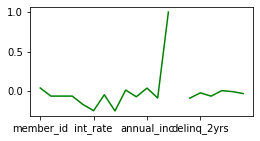

In [27]:
correlation = loans.corr()

(correlation['loan_status'][0:20]).plot(color='green')

print(correlation['loan_status'][0:20])

pub_rec                       -0.025446
revol_bal                      0.018017
revol_util                    -0.061130
total_acc                      0.009924
initial_list_status           -0.009168
out_prncp                     -0.006826
out_prncp_inv                 -0.006826
total_pymnt                    0.312947
total_pymnt_inv                0.312511
total_rec_prncp                0.434463
total_rec_int                 -0.049139
total_rec_late_fee            -0.141432
recoveries                    -0.497857
collection_recovery_fee       -0.471484
last_pymnt_amnt                0.349371
collections_12_mths_ex_med    -0.004873
mths_since_last_major_derog    0.003483
policy_code                         NaN
application_type              -0.012801
annual_inc_joint              -0.006200
Name: loan_status, dtype: float64


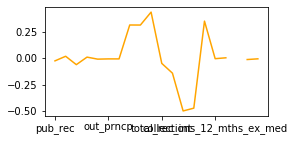

In [28]:
print(correlation['loan_status'][20:40])
(correlation['loan_status'][20:40]).plot(color='orange')

dti_joint                   -0.018986
verification_status_joint   -0.014493
acc_now_delinq              -0.003873
tot_coll_amt                 0.000459
tot_cur_bal                  0.069046
open_acc_6m                 -0.052836
open_act_il                 -0.029200
open_il_12m                 -0.041062
open_il_24m                 -0.042392
mths_since_rcnt_il           0.009477
total_bal_il                 0.003298
il_util                     -0.024302
open_rv_12m                 -0.037961
open_rv_24m                 -0.049384
max_bal_bc                   0.020889
all_util                    -0.055698
total_rev_hi_lim             0.049570
inq_fi                      -0.019642
total_cu_tl                  0.010946
inq_last_12m                -0.032153
Name: loan_status, dtype: float64


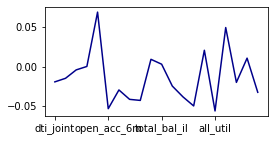

In [29]:
print(correlation['loan_status'][40:60])
(correlation['loan_status'][40:60]).plot(color='darkblue')

acc_open_past_24mths             -0.093985
avg_cur_bal                       0.076834
bc_open_to_buy                    0.080123
bc_util                          -0.065942
chargeoff_within_12_mths         -0.003266
delinq_amnt                      -0.002953
mo_sin_old_il_acct                0.023477
mo_sin_old_rev_tl_op              0.046354
mo_sin_rcnt_rev_tl_op             0.051473
mo_sin_rcnt_tl                    0.051869
mort_acc                          0.072179
mths_since_recent_bc              0.048895
mths_since_recent_bc_dlq          0.005602
mths_since_recent_inq             0.049435
mths_since_recent_revol_delinq    0.007099
num_accts_ever_120_pd            -0.009329
num_actv_bc_tl                   -0.041718
num_actv_rev_tl                  -0.070464
num_bc_sats                      -0.015077
num_bc_tl                         0.014731
Name: loan_status, dtype: float64


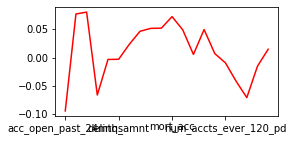

In [30]:
print(correlation['loan_status'][60:80])
(correlation['loan_status'][60:80]).plot(color='red')

num_il_tl                    -0.005750
num_op_rev_tl                -0.033283
num_rev_accts                 0.002746
num_rev_tl_bal_gt_0          -0.069212
num_sats                     -0.026848
num_tl_120dpd_2m             -0.001287
num_tl_30dpd                 -0.002588
num_tl_90g_dpd_24m           -0.009300
num_tl_op_past_12m           -0.079196
pct_tl_nvr_dlq                0.010019
percent_bc_gt_75             -0.067010
pub_rec_bankruptcies         -0.024468
tax_liens                    -0.009446
tot_hi_cred_lim               0.075883
total_bal_ex_mort             0.003920
total_bc_limit                0.069545
total_il_high_credit_limit    0.002246
revol_bal_joint              -0.008375
sec_app_inq_last_6mths       -0.019437
sec_app_mort_acc              0.004907
Name: loan_status, dtype: float64


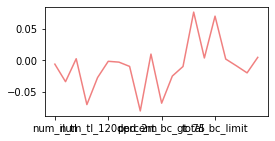

In [31]:
print(correlation['loan_status'][80:100])
(correlation['loan_status'][80:100]).plot(color='lightcoral')

sec_app_open_acc                             -0.008823
sec_app_revol_util                           -0.014506
sec_app_open_act_il                          -0.008577
sec_app_num_rev_accts                        -0.006562
sec_app_chargeoff_within_12_mths             -0.009210
sec_app_collections_12_mths_ex_med           -0.014340
sec_app_mths_since_last_major_derog          -0.005323
hardship_flag                                -0.001801
hardship_type                                 0.081234
hardship_reason                               0.044914
hardship_status                               0.086002
deferral_term                                      NaN
hardship_amount                              -0.070794
hardship_length                              -0.081234
hardship_dpd                                 -0.076448
hardship_loan_status                          0.068298
orig_projected_additional_accrued_interest   -0.011100
hardship_payoff_balance_amount               -0.073898
hardship_l

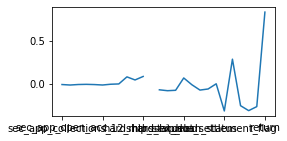

In [32]:
print(correlation['loan_status'][100:126])
(correlation['loan_status'][100:126]).plot()

<h2> loan status is dependent variable and remaining highly correlated features independent variables </h2>

In [33]:
X= loans[['term','int_rate','grade','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_late_fee','recoveries',
'collection_recovery_fee','last_pymnt_amnt','debt_settlement_flag','settlement_status','settlement_amount',
'settlement_percentage','settlement_term','return']]

Y = loans['loan_status']

<h2> Model Evaluation </h2>

In [50]:
#Model Evaluation

def evaluation(cm):
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    #Calculating precision
    def Precision_Cal(TP,FP):
        return TP/(TP+FP)

    #Calculating recall
    def Recall_Cal(TP,FN):
        return TP/(TP+FN)

    #Calculating F1 score
    def F1_Cal(precision,recall):
        f1 = 2*((precision * recall)/(precision+recall))
        print('F1 Score = ', f1)
        #print('F1 % = ', f1*100)

    #Calculating Error Rate
    def Err_Cal(TP,FP,FN,TN):
        return ((FP+FN)/(TP+FP+FN+TN))

    precision = Precision_Cal(TP,FP)
    print('Precision = ', precision)

    recall = Recall_Cal(TP,FN)
    print('Recall = ', recall)

    F1_Cal(precision,recall)

    Err_Rate = Err_Cal(TP,FP,FN,TN)
    print('Error Rate = ', Err_Rate)

    #Accuracy is 1-error rate
    print('Accuracy = ', 1-Err_Rate)
    
def rocCurve(y_true, y_pred, roc):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
def plotConfusionMatrix(cm):
    np.set_printoptions(suppress=True)
    mp.rc("figure", figsize=(4, 2))

    hm = sns.heatmap(cm, 
                cbar=False,
                annot=True, 
                square=True,
                fmt='d',
                yticklabels=['fully paid','default'],
                xticklabels=['fully paid','default'],
                cmap='Blues'
                )
    plt.title('Confusion matrix - Validation dataset')
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.tight_layout()
    plt.savefig('confmat_valid.eps', dpi=300)
    plt.show()

<h2>Train and test the XGBoost Classifier with 75% for training set and 25% for testing set</h2>

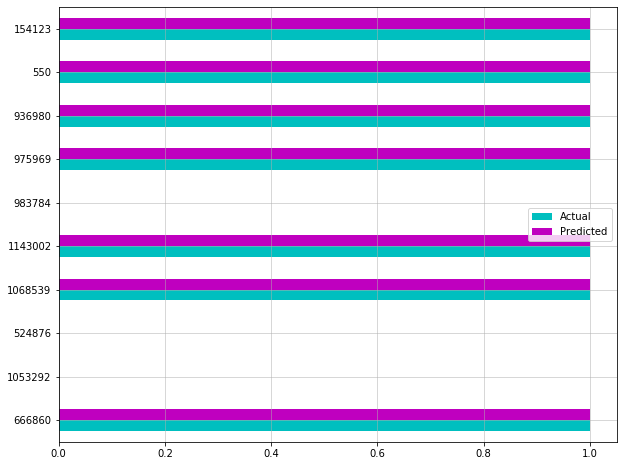

***************Evaluation*****************


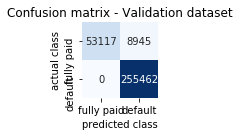

Precision =  0.8558699365150978
Recall =  1.0
F1 Score =  0.9223382734699902
Error Rate =  0.02817109887756516
Accuracy =  0.9718289011224348
ROC-AUC 0.9279349682575488


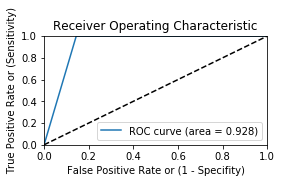

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=42)

xg_cl = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 10, n_estimators = 10)

xg_cl.fit(X_train,Y_train)

#Prediction
Y_predicted = xg_cl.predict(X_test)


# #Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_predicted})

prd = pred_df.head(10)

prd

#plot the values for comparison

prd.plot(kind='barh',figsize=(10,8), color=['c','m'])
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

print("***************Evaluation*****************")

mnb_roc_auc = roc_auc_score(Y_test, Y_predicted, average= 'micro')

#confusion matrix for count vector
mnb_cm = metrics.confusion_matrix(Y_test, Y_predicted, labels=[0,1])

#plot the confusion Matrix
plotConfusionMatrix(mnb_cm)

rocCurve(Y_test, Y_predicted, mnb_roc_auc)

#Evaluation
evaluation(mnb_cm)
print("ROC-AUC", mnb_roc_auc)

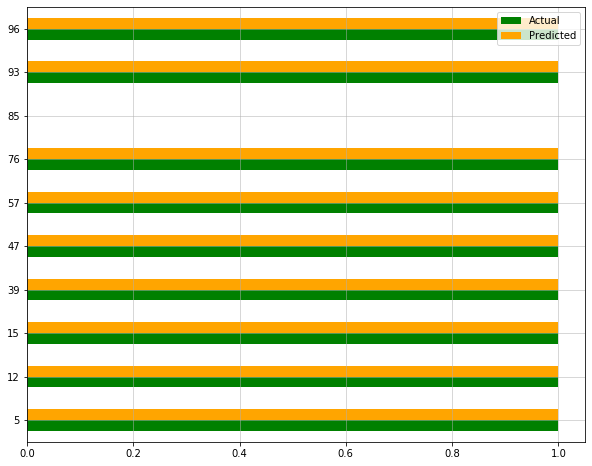

***************Evaluation*****************


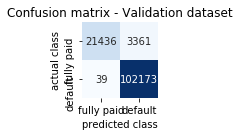

Precision =  0.8644594104125499
Recall =  0.9981839348079162
F1 Score =  0.926521438450899
Error Rate =  0.026769756473950666
Accuracy =  0.9732302435260494
ROC-AUC 0.932038925258715


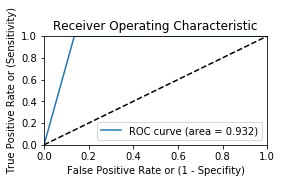

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=10, random_state=30, shuffle=True)

for train_index, test_index in cv.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    
xg_cl = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 5, n_estimators = 5)

xg_cl.fit(X_train,Y_train)

#Prediction
Y_predicted = xg_cl.predict(X_test)


#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_predicted})

prd = pred_df.head(10)


#plot the values for comparison

prd.plot(kind='barh',figsize=(10,8), color=['green','orange'])
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

print("***************Evaluation*****************")

mnb_roc_auc = roc_auc_score(Y_test, Y_predicted, average= 'micro')

#confusion matrix for count vector
mnb_cm = metrics.confusion_matrix(Y_test, Y_predicted, labels=[0,1])

#plot the confusion Matrix
plotConfusionMatrix(mnb_cm)

rocCurve(Y_test, Y_predicted, mnb_roc_auc)

#Evaluation
evaluation(mnb_cm)
print("ROC-AUC", mnb_roc_auc)